# Neuro-symbolic integration report

Instructor: Prof. Jędrzej Potoniec

Authors:
- Kacper Dobek 148247
- Daniel Jankowski 148257

This report is a summary of the work done in the course Neuro-symbolic integration at the Poznan University of Technology as an addition our master's thesis *Modeling Retinal Cells with Neural Differential
Equations*. We aimed to develop a better understanding of our dataset and use neurosymbolic techniques to make an attempt at transfering the dynamical system dynamics to a symbolic representation.

Bibliography:

- Maheswaranathan, N., McIntosh, L. T., Tanaka, H., Grant, S., Kastner, D. B.,
Melander, J. B., Nayebi, A., Brezovec, L. E., Wang, J. H., Ganguli, S., and
Baccus, S. A. Interpreting the retinal neural code for natural scenes: From
computations to neurons. Neuron, 111(17):2742–2755.e4, 2023. ISSN 0896-6273. doi:10.1016/j.neuron.2023.06.007. URL https://www.cell.com/neuron/abstract/S0896-6273(23)00467-1.
- Hasani, R., Lechner, M., Amini, A., Liebenwein, L., Ray, A., Tschaikowski,
M., Teschl, G., and Rus, D. Closed-form continuous-time neural net-
works. Nature Machine Intelligence, 4(11):992–1003, 2022. ISSN 2522-5839. doi:10.1038/s42256-022-00556-7. URL https://www.nature.com/articles/s42256-022-00556-7.

### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

from h5py import File

sns.set(style="whitegrid", font_scale=1.3)

%matplotlib inline

In [2]:
plot_dir = Path("plots")
plot_dir.mkdir(exist_ok=True)

### Part 1: Firing rate rise detection EDA

The first part of this report focuses on the exploratory data analysis of firing rate increases. Our objective is to analyze and visualize the data to better understand the mechanisms underlying rises in firing rate.

We hypothesize that increases in firing rate are triggered by changes in the input signal, potentially with a temporal delay. The following analysis aims to investigate and validate this assumption.

In [21]:
def read_h5_to_numpy(file_path: str, subset_type: str, response_type: str):
    """
    Reads data from an HDF5 file and converts it to numpy arrays. Normalizes the output data if the scaler is provided.
    Returns:
        Tuple[ndarray[Any, dtype[Any]], ndarray[Any, dtype[Any]]]: A tuple containing the input data (X) and the output data (y).
    """  # noqa: E501
    with File(file_path, "r") as h5file:
        # Read as numpy arrays
        X = np.asarray(h5file[subset_type]["stimulus"])
        y = np.asarray(h5file[subset_type]["response"][response_type])
    X = X.astype("float32") / 255.0
    y = y.astype("float32")

    return X, y

In [22]:
x, y = read_h5_to_numpy(
    "../data/neural_code_data/naturalscene.h5", "train", "firing_rate_10ms"
)

Let's show a few examples of input frames

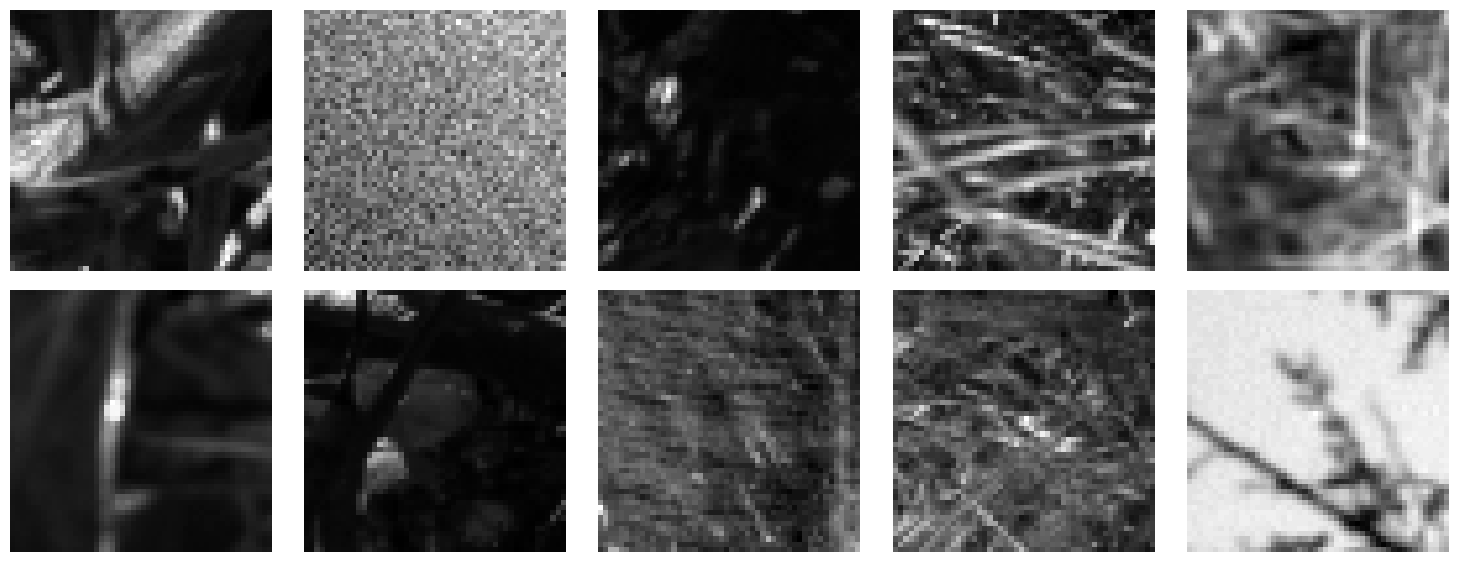

In [23]:
np.random.seed(42)
random_indices = np.random.choice(x.shape[0], 10, replace=False)
x_sample = x[random_indices]
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_sample[i], cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()

The function below plots the last N images along with response values below them when a rising firing rate is detected.


In [24]:
def plot_spike_images(
    responses: np.ndarray, images: np.ndarray, N: int = 5, save=False
):
    """
    Plots the last N images when a rising firing rate (response > 0) is detected and also plots the responses below them.

    Parameters:
    - responses: 1D numpy array of neural responses.
    - images: 3D numpy array of shape (num_samples, 50, 50) containing grayscale images.
    - N: Number of images to plot before the detected spike.
    """
    spike_indices = np.where(responses > 0)[0]  # Indices where response > 0

    if len(spike_indices) == 0:
        print("No spikes detected.")
        return

    for spike_idx in spike_indices:
        start_idx = max(0, spike_idx - N)  # Ensure valid index range
        selected_indices = np.arange(start_idx, spike_idx + 1)
        selected_responses = responses[selected_indices]

        fig = plt.figure(figsize=(12, 4))
        gs = fig.add_gridspec(2, spike_idx - start_idx + 1, height_ratios=[3, 1])
        # fig.suptitle(f"Spike detected: {responses[spike_idx]:.2f} at index {spike_idx}")

        for i, idx in enumerate(selected_indices):
            ax = fig.add_subplot(gs[0, i])
            ax.imshow(images[idx], cmap="gray")
            ax.axis("off")
            ax.set_title(str(idx))

        ax_response = fig.add_subplot(gs[1, :])
        ax_response.plot(
            selected_indices, selected_responses, marker="o", linestyle="-", color="b"
        )
        ax_response.set_title("RGC Responses")
        ax_response.set_xlabel("Time step")
        ax_response.set_ylabel("Firing rate [Hz]")

        plt.tight_layout()
        plt.show()
        if save:
            fig.savefig(f"plots/spike_images_{spike_idx}.pdf")

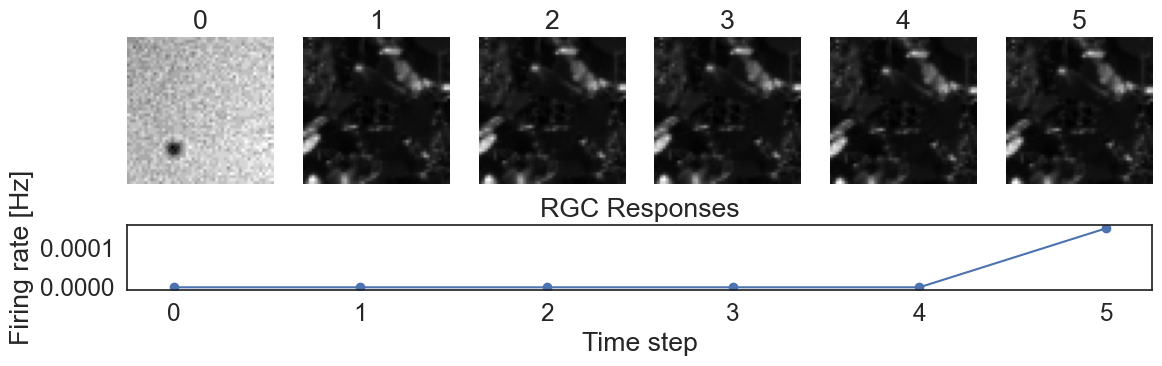

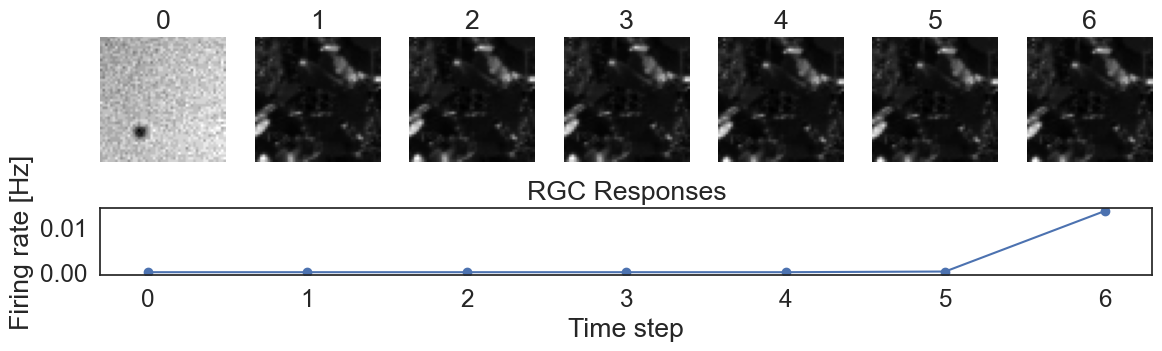

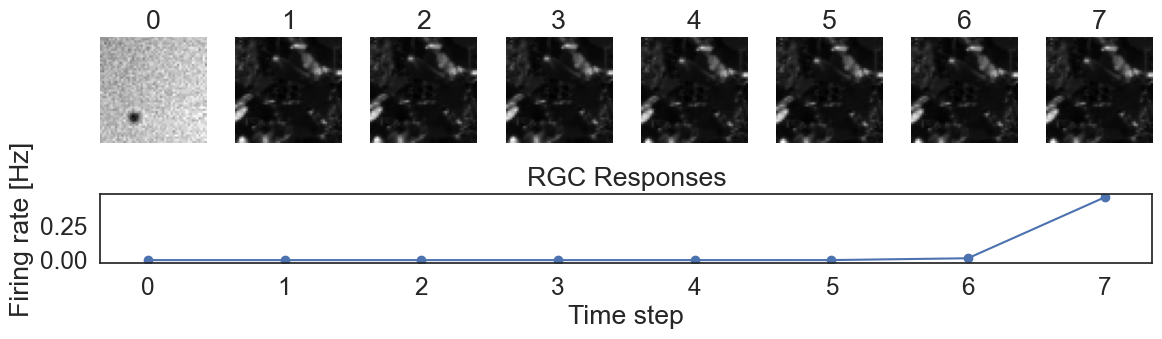

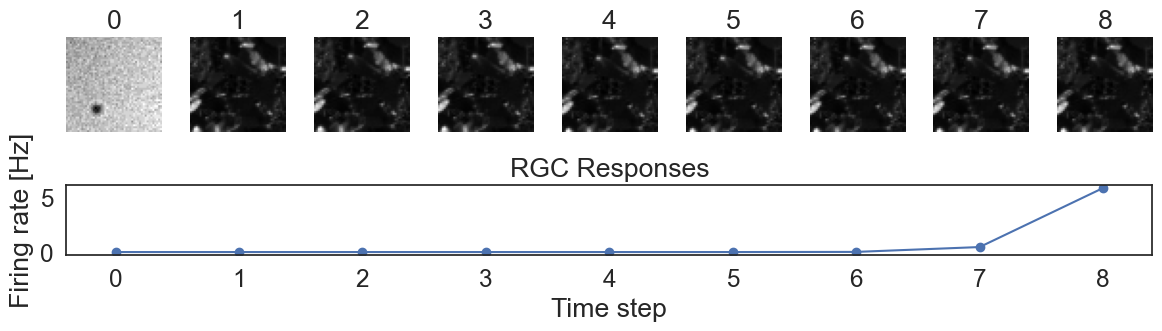

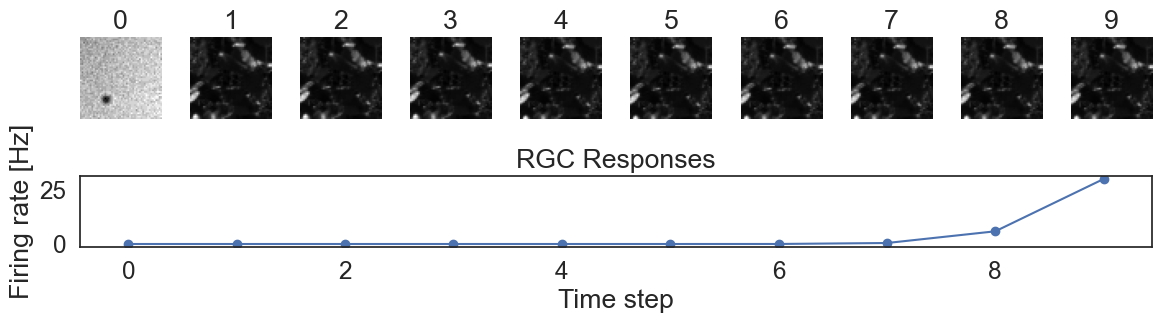

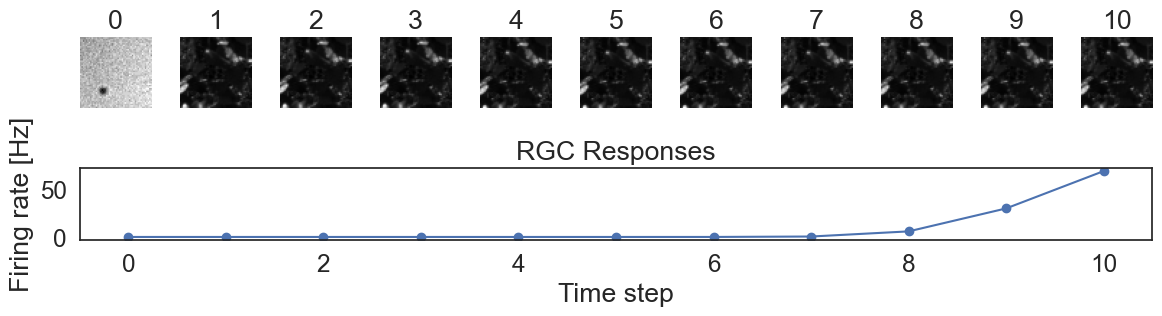

In [25]:
y_0 = y[0]  # Select the first channel

plot_spike_images(y_0[809:820], x[809:820], N=10, save=False)

The dataset consists of recordings from a real biological nervous system. As such, it inherently contains biological variability and noise, both from the neural activity itself and the recording process. The firings are sparse, with approximately $80\%$ of the response values being equal to zero. When a high-frequency firing occurs, it is typically brief, with a short onset followed by a rapid return to a low value. Such events are most likely present shortly after changes in the visual scene, although they appear with a characteristic temporal lag - usually about $8-12$ frames later from the moment when the scene changes.

### Part 2: Approximation of CfC dynamics using PySINDy

In the second part of the project, we aim to express the dynamics of the CfC component using symbolic equations. We attach the `extract_equation.py` script to this report. The script was used to extract the equation of the system using the [PySINDy Python package](https://pysindy.readthedocs.io/en/latest/).

This code implements a pipeline for extracting and analyzing interpretable dynamical equations from the hidden states of the neural network we designed, composed of a convolutional encoder and a Closed-form Continuous-time network (CfC). The main goal is to use the PySINDy (Sparse Identification of Nonlinear Dynamics) framework to approximate the evolution of the model’s hidden states with explicit, human-readable differential equations.

The workflow begins by loading a trained neural network and dataset, then pruning the CfC model to reduce its complexity (global pruning of the $20%$ lowest weights according to the L1 norm). The code collects hidden state trajectories from the CfC component as the model processes the training data. We fit select only 20 000 data points from the training set to reduce the computational burden. These trajectories are used to fit a SINDy model, which identifies a sparse set of nonlinear differential equations that best describe the hidden state dynamics. The identified equations are saved in a txt file.

The code also provides tools for simulating the hidden state evolution using the learned SINDy equations, starting from an initial state derived from the encoder.  We save the predicted responses and the targets to compare the model's performance against the original neural network. Additionally, the script supports batch processing of multiple models and parallel evaluation of SINDy equation (using `joblib`), enhancing efficiency.

Despite the attempts to simplify the equations by removing terms with small coefficients, the resulting equations remain complex and contain many terms. Below, we present the extracted equation for the first output variable, `h0`. The equation is a polynomial of degree 3 (including interactions). Although other libraries such as Fourier are available in PySINDy, we decided to use the polynomial library, as it showed the best results in our experiments.

$(h_0)' = 0.534 1 + 10.377 h_0 + 13.713 h_1 + -24.688 h_2 + -5.088 h_3 + 15.654 h_4 + -14.791 h_5 + 23.970 h_6 + -23.659 h_7 + 24.527 h_8 + -107.420 h_0^2 + -102.237 h_0 h_1 + 504.749 h_0 h_2 + -51.477 h_0 h_3 + 122.794 h_0 h_4 + -96.619 h_0 h_5 + -4.978 h_0 h_6 + -89.888 h_0 h_7 + -212.798 h_0 h_8 + -1571.400 h_1^2 + 1292.621 h_1 h_2 + 194.513 h_1 h_3 + 364.650 h_1 h_4 + -204.997 h_1 h_5 + 102.619 h_1 h_6 + 1472.792 h_1 h_7 + 3387.343 h_1 h_8 + -1111.397 h_2^2 + -53.275 h_2 h_3 + -133.208 h_2 h_4 + 510.764 h_2 h_5 + 477.261 h_2 h_6 + -357.330 h_2 h_7 + -597.828 h_2 h_8 + 37.741 h_3^2 + -142.205 h_3 h_4 + -11.095 h_3 h_5 + -216.188 h_3 h_6 + -73.328 h_3 h_7 + -533.328 h_3 h_8 + 90.157 h_4^2 + -93.648 h_4 h_5 + 245.726 h_4 h_6 + -287.923 h_4 h_7 + 109.456 h_4 h_8 + 69.291 h_5^2 + -38.328 h_5 h_6 + -39.898 h_5 h_7 + 378.854 h_5 h_8 + 94.725 h_6^2 + -141.611 h_6 h_7 + 225.512 h_6 h_8 + -208.231 h_7^2 + 48.876 h_7 h_8 + 30.757 h_8^2 + -121.549 h_0^3 + 1833.684 h_0^2 h_1 + 606.277 h_0^2 h_2 + -204.520 h_0^2 h_3 + -966.325 h_0^2 h_4 + 69.220 h_0^2 h_5 + -1239.522 h_0^2 h_6 + -13.777 h_0^2 h_7 + -1306.480 h_0^2 h_8 + -5743.414 h_0 h_1^2 + -3870.399 h_0 h_1 h_2 + 3713.875 h_0 h_1 h_3 + -527.637 h_0 h_1 h_4 + 145.666 h_0 h_1 h_5 + 3429.980 h_0 h_1 h_6 + 3740.344 h_0 h_1 h_7 + 8803.036 h_0 h_1 h_8 + -1294.063 h_0 h_2^2 + -1217.918 h_0 h_2 h_3 + 4715.536 h_0 h_2 h_4 + 1497.172 h_0 h_2 h_5 + 5749.602 h_0 h_2 h_6 + -623.769 h_0 h_2 h_7 + 6614.306 h_0 h_2 h_8 + 19.499 h_0 h_3^2 + -616.337 h_0 h_3 h_4 + 313.868 h_0 h_3 h_5 + -1337.583 h_0 h_3 h_6 + -852.023 h_0 h_3 h_7 + -3389.707 h_0 h_3 h_8 + 545.026 h_0 h_4^2 + -514.091 h_0 h_4 h_5 + 812.314 h_0 h_4 h_6 + -962.669 h_0 h_4 h_7 + 289.901 h_0 h_4 h_8 + 33.230 h_0 h_5^2 + -14.329 h_0 h_5 h_6 + -170.486 h_0 h_5 h_7 + 454.253 h_0 h_5 h_8 + 360.520 h_0 h_6^2 + -1485.576 h_0 h_6 h_7 + 2593.290 h_0 h_6 h_8 + -338.053 h_0 h_7^2 + -1433.292 h_0 h_7 h_8 + 6771.100 h_0 h_8^2 + 15111.141 h_1^3 + 18807.164 h_1^2 h_2 + -3148.564 h_1^2 h_3 + -13978.811 h_1^2 h_4 + -4717.872 h_1^2 h_5 + -22936.164 h_1^2 h_6 + -4289.414 h_1^2 h_7 + -42459.758 h_1^2 h_8 + -10636.998 h_1 h_2^2 + -1196.713 h_1 h_2 h_3 + -752.727 h_1 h_2 h_4 + 9830.820 h_1 h_2 h_5 + -5501.971 h_1 h_2 h_6 + -8853.610 h_1 h_2 h_7 + -39207.492 h_1 h_2 h_8 + -1312.913 h_1 h_3^2 + 2756.687 h_1 h_3 h_4 + 1408.110 h_1 h_3 h_5 + 5164.589 h_1 h_3 h_6 + -4.442 h_1 h_3 h_7 + 16534.850 h_1 h_3 h_8 + 2293.476 h_1 h_4^2 + -1362.836 h_1 h_4 h_5 + 2296.949 h_1 h_4 h_6 + 10620.373 h_1 h_4 h_7 + 12017.040 h_1 h_4 h_8 + -2317.449 h_1 h_5^2 + -3472.120 h_1 h_5 h_6 + -932.895 h_1 h_5 h_7 + 115.146 h_1 h_5 h_8 + -1485.884 h_1 h_6^2 + 13482.284 h_1 h_6 h_7 + -1440.980 h_1 h_6 h_8 + -1471.188 h_1 h_7^2 + 15148.195 h_1 h_7 h_8 + -49971.086 h_1 h_8^2 + 4388.114 h_2^3 + 752.592 h_2^2 h_3 + -3764.700 h_2^2 h_4 + -8714.616 h_2^2 h_5 + -5782.956 h_2^2 h_6 + 535.907 h_2^2 h_7 + 8960.903 h_2^2 h_8 + -66.942 h_2 h_3^2 + 853.181 h_2 h_3 h_4 + -1186.433 h_2 h_3 h_5 + 3094.247 h_2 h_3 h_6 + 932.541 h_2 h_3 h_7 + 7439.275 h_2 h_3 h_8 + -680.857 h_2 h_4^2 + 1463.542 h_2 h_4 h_5 + 491.968 h_2 h_4 h_6 + 477.755 h_2 h_4 h_7 + -3711.868 h_2 h_4 h_8 + 1176.946 h_2 h_5^2 + 1288.895 h_2 h_5 h_6 + 654.283 h_2 h_5 h_7 + -7210.557 h_2 h_5 h_8 + 1128.432 h_2 h_6^2 + 2439.257 h_2 h_6 h_7 + -8914.517 h_2 h_6 h_8 + 1423.539 h_2 h_7^2 + 6102.950 h_2 h_7 h_8 + 1808.321 h_2 h_8^2 + 97.006 h_3^3 + 116.993 h_3^2 h_4 + -24.957 h_3^2 h_5 + -227.803 h_3^2 h_6 + 356.810 h_3^2 h_7 + -1863.301 h_3^2 h_8 + -771.572 h_3 h_4^2 + -56.268 h_3 h_4 h_5 + -1627.748 h_3 h_4 h_6 + -979.536 h_3 h_4 h_7 + -1532.225 h_3 h_4 h_8 + 190.431 h_3 h_5^2 + 525.477 h_3 h_5 h_6 + -158.533 h_3 h_5 h_7 + 53.461 h_3 h_5 h_8 + -585.906 h_3 h_6^2 + -1501.524 h_3 h_6 h_7 + 1628.434 h_3 h_6 h_8 + 201.707 h_3 h_7^2 + -3795.491 h_3 h_7 h_8 + 10483.943 h_3 h_8^2 + 145.686 h_4^3 + 205.228 h_4^2 h_5 + 627.173 h_4^2 h_6 + -1188.145 h_4^2 h_7 + 122.490 h_4^2 h_8 + 62.928 h_4 h_5^2 + 864.804 h_4 h_5 h_6 + 328.773 h_4 h_5 h_7 + 2673.697 h_4 h_5 h_8 + 663.552 h_4 h_6^2 + -1798.931 h_4 h_6 h_7 + 1118.008 h_4 h_6 h_8 + -1432.640 h_4 h_7^2 + -306.694 h_4 h_7 h_8 + -794.410 h_4 h_8^2 + 55.647 h_5^3 + -560.710 h_5^2 h_6 + 844.252 h_5^2 h_7 + -1741.266 h_5^2 h_8 + 544.898 h_5 h_6^2 + 581.506 h_5 h_6 h_7 + 469.582 h_5 h_6 h_8 + 255.944 h_5 h_7^2 + 1335.999 h_5 h_7 h_8 + -2620.509 h_5 h_8^2 + 249.998 h_6^3 + -372.204 h_6^2 h_7 + 795.299 h_6^2 h_8 + -1899.068 h_6 h_7^2 + 1081.207 h_6 h_7 h_8 + -2238.253 h_6 h_8^2 + 133.637 h_7^3 + -915.008 h_7^2 h_8 + 3398.197 h_7 h_8^2 + -6991.128 h_8^3$

We will nos load predicted responses and targets to compare the model's performance against the original neural network on the validation set.

In [13]:
pred_dir = Path("../sindy/compare_models")
pred_files = pred_dir.glob("*.csv")

# Create a dictionary to store the dataframes
pred_dict = {}

for pred_file in pred_files:
    # Read the csv file
    df = pd.read_csv(pred_file)
    # Get the model name
    model_name = pred_file.stem
    # Store the dataframe in the dictionary
    pred_dict[model_name] = df

print(pred_dict.keys())

dict_keys(['CfC', 'CfC-pruned', 'Sindy-pruned', 'Sindy', 'Target'])


In [14]:
pred_dict["Target"].head()

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,0.201739,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.121669,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.026943,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.002191,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000065,0.0,0.0,0.0,0.0,0.0


In [15]:
custom_colors = sns.color_palette("tab10")

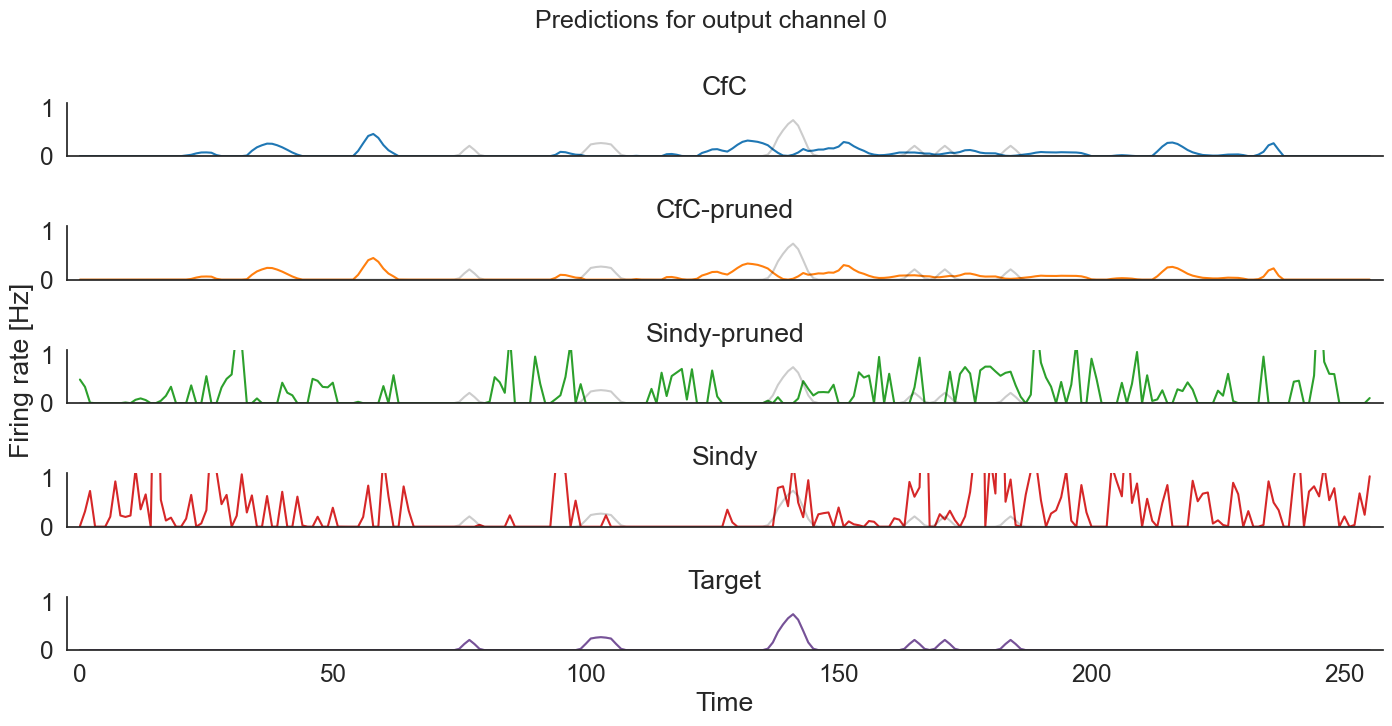

In [27]:
# Set the style
sns.set_context("paper")
# Set font_scale according to needs
sns.set(style="white", font_scale=1.6)

# Create a figure and axis
n_subplots = len(pred_dict)
fig, axes = plt.subplots(
    n_subplots,
    1,
    figsize=(
        14,
        1.5 * n_subplots,
    ),
    sharey=True,
)

# Select output channel
output_channel = "0"

# Iterate over the dictionary
for i, (model_name, df) in enumerate(pred_dict.items()):
    # Create a scatter plot
    x_axis_values = df[output_channel].index
    sns.lineplot(
        x=x_axis_values, y=output_channel, data=df, ax=axes[i], color=custom_colors[i]
    )
    # Plot the target values in background
    # Adjust data frame length
    target_df = pred_dict["Target"].iloc[: len(df)]
    sns.lineplot(
        x=target_df.index,
        y=output_channel,
        data=target_df,
        ax=axes[i],
        color="black",
        alpha=0.2,
    )
    # Add a title
    axes[i].set_title(model_name)
    axes[i].get_xaxis().set_visible(False)
    axes[i].set_ylabel("")
    axes[i].margins(x=0.01)
    axes[i].set_ylim(0, 1.1)

# Set x axis label for the last subplot
axes[-1].get_xaxis().set_visible(True)
axes[-1].set_xlabel("Time")

# Set y axis label for the figure
fig.text(-0.001, 0.5, "Firing rate [Hz]", va="center", rotation="vertical")

fig.suptitle(f"Predictions for output channel {output_channel}", fontsize=18)

sns.despine()
# Adjust the layout
plt.tight_layout()
plt.show()

As we can see in the plot above, the sindy prediction are noisy and do not match the target values well. The model is not able to capture the dynamics of the system, which is likely due to the complexity of the system and the limitations of the PySINDy library.

In [17]:
# Calculate mae for each model
mae_dict = {}
for model_name, df in pred_dict.items():
    if model_name == "Target":
        continue
    # Calculate the mean absolute error
    mae = np.mean(np.abs(df - pred_dict["Target"]))
    mae_dict[model_name] = mae

# Create a DataFrame from the mae_dict
mae_df = pd.DataFrame.from_dict(mae_dict, orient="index", columns=["MAE"])
# Sort the DataFrame by MAE
mae_df = mae_df.sort_values(by="MAE", ascending=True)

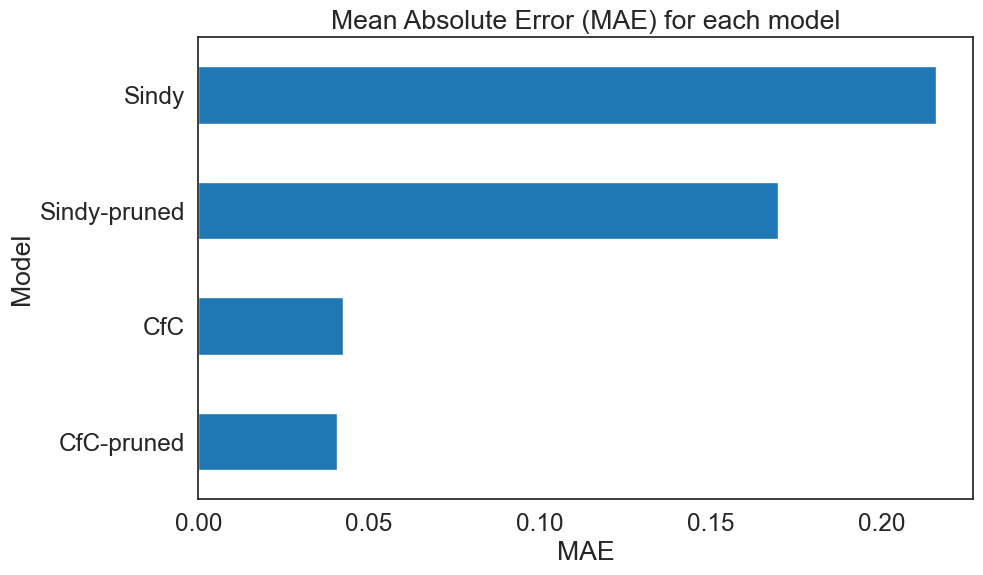

In [20]:
mae_df.plot(
    kind="barh",
    figsize=(10, 6),
    color=custom_colors[: len(mae_df)],
    legend=False,
    title="Mean Absolute Error (MAE) for each model",
    xlabel="MAE",
    ylabel="Model",
)
plt.show()

The plot above shows that the MAE of the pruned CfC model is close to the MAE of the original CfC model, which means that the pruning did not significantly affect the performance of the model.  However, the MAE of the SINDy models based both on the original CfC and the pruned CfC models is significantly higher than the MAE of the CfC models. This indicates that the SINDy models are not able to capture the dynamics of the dynamical system well.